### Start importing all libraries

In [1]:
# Global
import tqdm
import numpy as np
import matplotlib.pyplot as plt

# Local
import examples_utils as eu
import fastPTA.utils as ut
import fastPTA.plotting_functions as pf
from fastPTA.Fisher_code import compute_fisher

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


### Constants to be used in the analysis

In [2]:
# Total observation time in years
T_obs_yrs = 16.03

# Number of frequencies used in the analysis
n_frequencies = 30

# Number of pulsars in the analysis
n_pulsars = 25

# Specify the type of noise to be used in the analysis
which_experiment = eu.EPTAlike

### Set the inputs for the Fisher

In [3]:
# Dictionary with the kwargs to generete the pulsar catalogs
generate_catalog_kwargs = {
    "n_pulsars": n_pulsars,
    "save_catalog": False,
    **which_experiment,
}

# Dictionary with the kwargs to generate noise and orf tensors
get_tensors_kwargs = {
    "add_curn": False,
    "regenerate_catalog": True,
}

### Prepare the model to scan over

In [4]:
# Set the label to specify the signal model
signal_label = "power_law"

# Labels for the signal parameters
parameter_labels = [
    r"$\alpha_{\rm PL}$",
    r"$n_{\rm T}$",
]

# The analysis assumes a power law template, specify here the input parameters
log_amplitude = -7.1995  # log amplitude
tilt = 2.0  # Tilt

# Index to scan over
parameter_index = 0

# Range of the parameter to scan over
parameter_range = np.linspace(-8, -6, 11)

# Number of realizations to average over
n_realizations = 10

### Do the scan

In [5]:
# Assemble the vector with two signal parameters
s_params = np.array([log_amplitude, tilt])

# Define the array to store the results
results = np.zeros(shape=(len(parameter_range), n_realizations, len(s_params)))

for i in tqdm.tqdm(range(len(parameter_range))):
    for n in range(n_realizations):
        # Update the parameter of interest
        s_params[parameter_index] = parameter_range[i]

        # Dictionary with the kwargs to generate the fisher matrix
        fisher_kwargs = {
            "T_obs_yrs": T_obs_yrs,
            "n_frequencies": n_frequencies,
            "signal_label": signal_label,
            "signal_parameters": s_params,
        }

        # Compute the fisher matrix
        (
            frequency,
            signal,
            HD_functions_IJ,
            HD_coeffs,
            effective_noise,
            SNR,
            fisher,
        ) = compute_fisher(
            **fisher_kwargs,
            get_tensors_kwargs=get_tensors_kwargs,
            generate_catalog_kwargs=generate_catalog_kwargs,
        )

        # Compute the covariance matrix
        covariance = ut.compute_inverse(fisher)

        # Store the results
        results[i, n] = np.sqrt(np.diag(covariance))

100%|██████████| 11/11 [00:03<00:00,  3.21it/s]


### Plot the results

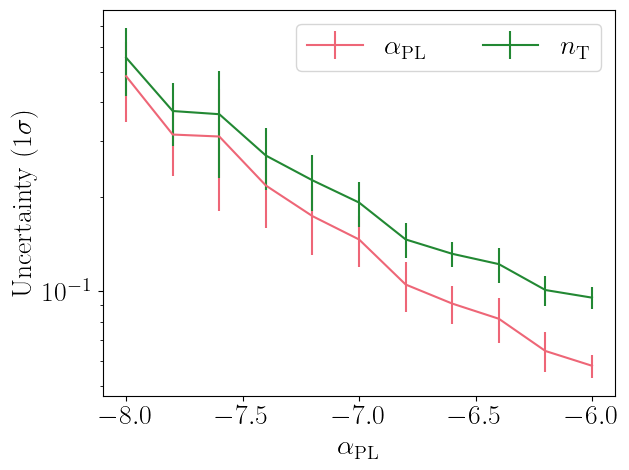

In [6]:
cols = list(pf.my_colormap.keys())
for i in range(len(s_params)):
    plt.errorbar(
        parameter_range,
        np.mean(results, axis=1)[:, i],
        yerr=np.std(results, axis=1)[:, i],
        color=pf.my_colormap[cols[i]],
        label=parameter_labels[i],
    )

plt.yscale("log")

plt.ylabel(r"$\rm Uncertainty \ (1 \sigma)$")
plt.xlabel(parameter_labels[parameter_index])
plt.legend(loc=1, ncols=2)
plt.tight_layout()